# Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/home_detection/code


## Imports

Run the project setup file in `mobilkit` package to import commonly used names and settings into the global namespace.

In [2]:
import sys
sys.path.insert(0, '/home/umni2/a/umnilab/users/verma99/mk/mobilkit')
from mobilkit.umni import *

Import other packages

In [3]:
import contextily as ctx
import haversine as hs
from IPython.display import display, HTML
from matplotlib_scalebar.scalebar import ScaleBar
import osmnx
import shapely
from sklearn.cluster import AgglomerativeClustering, MeanShift
# from tqdm import tqdm

## Important paths

Some paths are taken from `mobilkit.umni`:
* `MK`: Root folder of all my projects: [/home/umni2/a/umnilab/users/verma99/mk](/home/umni2/a/umnilab/users/verma99/mk)
* `QUADRANT`: Folder containing the originally processed Quadrant data: [/home/umni2/a/umnilab/data/Quadrant](/home/umni2/a/umnilab/data/Quadrant)

In [4]:
# folder containing all processed data from this script
data_root = Path('../data')
# shapefile of all US counties
us_counties_file = MK / 'general/data/usa/counties.shp.zip'
# file containing the FIPS codes of the states
state_fips_file = MK / 'general/data/usa/state_fips.csv'
# folder containing the data of each state (used for getting CBG FIPS codes)
state_data_root = MK / 'general/data/states'
# folder containing the geometry layers of cities (mainly used to get land use maps)
cities_data_root = MK / 'general/data/cities'

# Inputs

## Parameters

In [5]:
params = {
    # --------------------------------------------------------
    # Data filtering and processing
    # --------------------------------------------------------
    # maximum allowed spatial error in the GPS data (meters)
    'max_gps_error': 50,
    # starting and ending hours of daytime (in military time)
    'day_hours': [6, 21],
    # the minimum total no. of pings which a user must have 
    # "during night" to be included in any home detection 
    # algorithm (except A3)
    'min_total_nightly_pings': 10,
    # duration of the slot (seconds) used for binning pings
    'slot_size': 30*60,
    # --------------------------------------------------------
    # Mean-shift clustering (A1 and A2)
    # --------------------------------------------------------
    'meanshift': {
        # kernel bandwidth radius (meters)
        'radius': 250,
        # other parameters (not much critical); for details,
        # see the documentation of `sklearn.cluster.MeanShift`
        'bin_seeding': True,
        'min_bin_freq': 2,
        'max_iter': 30,
        'cluster_all': False
    },
    # --------------------------------------------------------
    # Stay point method (A3) (Sadeghinasr et al. (2019))
    # --------------------------------------------------------
    'stay_pt': {
        # distance threshold (meters) for stay point detection
        'dist_thresh': 250,
        # time threshold (in seconds) for stay point detection
        'time_thresh': 30*60,
        # maximum intra-cluster distance (meters) for a stay region
        'intra_clust_dist': 250,
        # minimum total dwell time of a stay region (seconds) to 
        # be considered an eligible home location
        'min_total_dwell': 24*3600, # seconds
        # minimum dwell time (seconds) during night to be
        # considered eligible an eligible home location
        'min_night_dwell': 3*3600, # seconds
    },
    # --------------------------------------------------------
    # Grid frequency method (A4)
    # --------------------------------------------------------
    # size of the grid cell (meters) for the gridding
    'grid_cell_size': 20,
    # --------------------------------------------------------
    # Performance assessment
    # --------------------------------------------------------
    # buffer widths (meters) for M1 (residential detection rate)
    'resi_buffers': [5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 250, 300, 350, 400]
}

## Regions

In [6]:
class Region:
    """ A simple class for handling study regions (mostly MSAs). """
    def __init__(self, name: str, state: str, 
                 counties: list[str], root=data_root):
        self.name = name
        self.label = name.replace(' ', '_').lower()
        self.state_label = state.replace(' ', '_').lower()
        self.state = state
        self.counties = sorted(counties)
        # folder containing this region's data
        self.data = U.mkdir(root / str(self))
        # folder containing this region's geometry data
        self.geom = U.mkdir(self.data / 'geometry')
        self.datasets = set()

    def __repr__(self):
        return f'Region({self.name})'
    
    def __str__(self):
        return self.label

In [7]:
def load_region(name, state=None):
    rgn = Region(name, state, counties=[])
    rgn.cnty = gpd.read_file(rgn.geom / 'counties.gpkg')
    rgn.counties = sorted(list(rgn.cnty['name']))
    rgn.bbox = list(rgn.cnty.geometry.unary_union.bounds)
    return rgn

**[Austin MSA](https://en.wikipedia.org/wiki/Greater_Austin#Boundaries)**

In [8]:
austin = Region('Austin', 'Texas', [
    'Bastrop','Caldwell','Hays','Travis','Williamson'])

**[Baton Rouge MSA](https://en.wikipedia.org/wiki/Baton_Rouge_metropolitan_area#Parishes)**

In [9]:
baton_rouge = Region('Baton Rouge', 'Louisiana', [
    'Ascension', 'East Baton Rouge', 'East Feliciana', 'Iberville', 'Livingston',
    'Pointe Coupee', 'St. Helena', 'West Baton Rouge', 'West Feliciana'])

**[Houston MSA](https://en.wikipedia.org/wiki/Greater_Houston#Counties)**

In [10]:
houston = Region('Houston', 'Texas', [
    'Austin','Brazoria','Chambers','Fort Bend','Galveston',
    'Harris','Liberty','Montgomery','Waller'])

**[Indianapolis MSA](https://en.wikipedia.org/wiki/Indianapolis_metropolitan_area#Counties)**

In [11]:
indy = Region('Indianapolis', 'Indiana', [
    'Boone','Brown','Hamilton','Hancock','Hendricks','Johnson',
    'Madison','Marion','Morgan','Putnam','Shelby'])

**[San Antonio MSA](https://en.wikipedia.org/wiki/Greater_San_Antonio#Counties)**

In [12]:
# regions = [austin, baton_rouge, houston, indy, san_antonio]
regions = [baton_rouge, indy, austin, houston]

## Datasets
A ds is a combination of a region and an analyis period.

In [13]:
class Dataset:
    def __init__(self, region, name, start_date, end_date):
        self.region = region
        self.name = name
        self.start = U.to_date(start_date)
        self.end = U.to_date(end_date)
        self.dates = U.dates(self.start, self.end)
        region.datasets.add(self)
        
    def fmt_dates(self, sep=' – ', fmt='%Y-%m-%d'):
        return sep.join([d.strftime(fmt) for d in [self.start, self.end]])
        
    def __repr__(self):
        return f'Dataset({self.region.name}: {self.name} ({self.fmt_dates()}))'

In [14]:
datasets = [
    # ------- Baton Rouge
    # Dataset(baton_rouge, 'D1', (2021, 8, 1), (2021, 8, 7)),
    # Dataset(baton_rouge, 'D2', (2021, 10, 1), (2021, 11, 30)),
    Dataset(baton_rouge, 'D3', (2021, 8, 1), (2021, 8, 25)),
    Dataset(baton_rouge, 'D4', (2021, 8, 26), (2021, 9, 7)),
    Dataset(baton_rouge, 'D5', (2021, 9, 8), (2021, 11, 30)),
    # ------- Indy
    # Dataset(indy, 'D1', (2021, 3, 1), (2021, 3, 7)),
    # Dataset(indy, 'D2', (2021, 3, 8), (2021, 3, 15)),
    Dataset(indy, 'D3', (2020, 3, 1), (2020, 3, 15)),
    Dataset(indy, 'D4', (2020, 3, 16), (2020, 3, 31)),
    Dataset(indy, 'D5', (2020, 3, 1), (2020, 3, 31)),
    # ------- Austin
    Dataset(austin, 'D1', (2021, 7, 1), (2021, 7, 7)),
    # Dataset(austin, 'D2', (2021, 7, 8), (2021, 7, 15)),
    # ------- San Antonio
    # Dataset(san_antonio, 'D1', (2021, 7, 1), (2021, 7, 7)),
    # Dataset(san_antonio, 'D2', (2021, 7, 8), (2021, 7, 15)),
    # ------- Houston
    Dataset(houston, 'D1', (2021, 7, 1), (2021, 7, 7)),
    # Dataset(houston, 'D2', (2021, 7, 8), (2021, 7, 15)),
]

# Prepare regional geometry

# Prepare pings

In [33]:
SP.start()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/17 18:59:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/17 18:59:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/04/17 18:59:28 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [34]:
def dist_m2deg(dist, lat, a=6_371_001, b=6_356_752):
    """
    Convert given distance in meters to degrees.
    See `mobilkit.geo.dist_m2deg` for more details.
    """
    lat = np.deg2rad(lat)
    curve_radius = (a * b) ** 2 / (
            (a * np.cos(lat)) ** 2 + (b * np.sin(lat)) ** 2) ** 1.5
    return float(np.rad2deg(dist / curve_radius))

In [35]:
def dist_deg2m(dist, lat, a=6_371_001, b=6_356_752):
    """
    Convert given distance in degrees to meters.
    See `mobilkit.geo.dist_m2deg` for more details.
    """
    lat = np.deg2rad(lat)
    curve_radius = (a * b) ** 2 / (
            (a * np.cos(lat)) ** 2 + (b * np.sin(lat)) ** 2) ** 1.5
    return float(np.deg2rad(dist) * curve_radius)

## Get regional data for all dates

In [36]:
def filter_pings(ds, max_error=params['max_gps_error'],
                 save=True, overwrite=False, pbar=True):
    rgn, dates = ds.region, ds.dates
    minx, miny, maxx, maxy = rgn.bbox
    if pbar: dates = tqdm(dates, desc=str(ds))
    for date in dates:
        outdir = rgn.data / f'pings/{date}'
        if outdir.exists() and not overwrite:
            continue
        try:
            # read the data and zip the pings
            path = QUADRANT / rgn.state.title() / date.strftime('%Y/%m/%d')
            df = SP.read_parquet(path)
            df = mk.gps.zip_pings(df, col='pings')
            # filter pings within bounding box & 
            # within spatial error threshold
            def filt_error(p): 
                return [x for x in p if x[ERR] <= max_error and 
                        minx <= x[LON] <= maxx and miny <= x[LAT] <= maxy]
            dtype = df.schema['pings'].dataType
            df = df.withColumn('pings', F.udf(filt_error, dtype)('pings'))
            df = df.filter(F.size('pings') > 0)
            df = mk.gps.unzip_pings(df)
            if save:
                mk.spark.write(df, outdir)
        except Exception as e:
            print(date, '\n'.join(str(e).split('\n')[:5]))

# %time x = filter_pings(aus); x

In [37]:
# t=??? {baro=>{1=>10:40, 2=>4:51, 3=>9:55}, indy=>{1=>5:58, 2=>6:48, 3=>0:00}, aus=>{1=>}, hous=>{1=>}}
for ds in datasets:
    filter_pings(ds, pbar=0)

## Make night pings

In [38]:
def get_nighttime_pings(ds, day_hrs=params['day_hours'],
                        min_total_pings=params['min_total_nightly_pings'],
                        save=True, overwrite=False):
    rgn, dates = ds.region, ds.dates
    outpath = rgn.data / f'night_pings/{ds.name}'
    if outpath.exists() and not overwrite:
        return SP.read_parquet(outpath)
    print(f'Processing {ds}')
    start_time = dt.datetime.now()
    # convert the start and end times of the daytime from hours to seconds
    start, end = [x * 3600 for x in day_hrs]
    # template for resolving the ping data directory for a given date
    def get_dir(date): return rgn.data / f'pings/{date}'
    # read the data of a date
    def read_date(date): return (SP.read_parquet(get_dir(date))
                                 .withColumn('date', F.lit(date)))
    # template for zipping the (x, y, t) coordinates of pings
    def zip_xyt(df):
        df = df.select('date', UID, F.arrays_zip(LON, LAT, TS).alias('pts'))
        return df.filter(F.size('pts') > 0)
    # template for filtering pings ((x, y, t)) with a boolean mask function
    def filt_xy(df, mask):
        return df.withColumn('pts', F.udf(lambda xyt: list(zip(*[
            (x, y, t) for x, y, t in xyt if mask(t)
        ])), T.array(T.array(T.float)))('pts'))
    dates = ds.dates
    # read the data of the first date
    df = zip_xyt(read_date(dates[0]))
    # for home locations, select only the evening time of the first day
    df = filt_xy(df, lambda t: t >= end)
    # for the remaining days, filter pings during both morning & evening
    for date in dates[1:]:
        df2 = zip_xyt(read_date(date))
        df = df.union(filt_xy(df2, lambda t: t <= start or t >= end))
    # for the last day, select only the morning time (if its data exists)
    next_day_dir = get_dir(dates[-1] + dt.timedelta(days=1))
    if next_day_dir.exists():
        df2 = zip_xyt(read_date(dates[-1] + dt.timedelta(days=1)))
        df = df.union(filt_xy(df2, lambda t: t <= start))
    df = df.filter(F.size('pts') > 0)
    # get day difference from the 1st day
    df = df.withColumn('day', (F.col('date') - min(dates)).cast(T.int16))
    # filter users who have sufficient records during this period
    df2 = df.select(UID, F.size('pts').alias('n'))
    df2 = df2.groupby(UID).agg(F.sum('n').alias('n_pings'))
    df2 = df2.filter(f'n_pings >= {min_total_pings}').select(UID)
    df = df.join(df2, on=UID)
    # split coordinates into two columns
    df = df.select(UID, 'day', *[F.col('pts')[i].alias(x) for i, x in
                                 enumerate([LON, LAT, TS])])
    if save:
        mk.spark.write(df, outpath)
    print(f'Runtime: {dt.datetime.now() - start_time}')
    return df
    
# %time x = get_nighttime_pings(datasets[0]); x

In [39]:
# t=31:21 ({baro=>{1=>3:36, 2=>1:15, 3=>14:07}, indy=>{1=>1:27, 2=>1:31, 3=>2:43}, aus=>{1=>1:36}, hous=>{1=>5:06}})
for ds in datasets:
    get_nighttime_pings(ds, overwrite=False)

## Make night superpings

In [40]:
def get_nighttime_superpings(ds, slot_size=params['slot_size'],
                             save=True, overwrite=False):
    rgn, ds_name = ds.region, ds.name
    outpath = rgn.data / f'night_superpings/{ds_name}'
    if outpath.exists() and not overwrite:
        return SP.read_parquet(outpath)
    print(f'Processing {ds}')
    start_time = dt.datetime.now()
    df = SP.read_parquet(rgn.data / f'night_pings/{ds_name}')
    df = df.select(UID, 'day', F.arrays_zip(LON, LAT, TS).alias('xyt'))
    df = df.select(UID, 'day', F.explode('xyt').alias('xyt'))
    df = df.select(UID, 'day', *[F.col('xyt')[x].alias(x) 
                                 for x in [LON, LAT, TS]])
    df = df.withColumn('slot', F.udf(lambda t: int(t / slot_size), T.int16)(TS))
    df = df.groupby(UID, 'day', 'slot').agg(
        *[F.collect_list(x).alias(x) for x in [LON, LAT]],
        *[F.mean(x).cast(T.float).alias('mean_' + x) for x in [LON, LAT]])
    df = df.withColumn('n_pings', F.size(LON).cast(T.int16))
    def get_rg(x, y):
        return dist_deg2m(np.sqrt(np.std(x)**2 + np.std(y)**2), np.mean(y))
    df = df.withColumn('rg', F.udf(get_rg, T.float)(LON, LAT))
    df = df.select(UID, 'day', 'slot', 'n_pings', 'mean_'+LON, 'mean_'+LAT, 'rg')
    if save:
        mk.spark.write(df, outpath)
    print(f'Runtime: {dt.datetime.now() - start_time}')
    return df
    
# %time x = get_nighttime_superpings(datasets[0]); x

In [41]:
# total time for aus + baro + hous + indy + sant = 3:20
for ds in datasets:
    get_nighttime_superpings(ds, overwrite=False)

# Home detection algorithms

## A0: Centroid

In [42]:
def get_homes_centroid(ds, save=True, overwrite=False):
    rgn, ds_name = ds.region, ds.name
    outpath = rgn.data / f'homes/{ds_name}/A0.parquet'
    if outpath.exists() and not overwrite:
        return SP.read_parquet(outpath)
    print(f'Processing {ds}')
    start_time = dt.datetime.now()
    df = SP.read_parquet(rgn.data / f'night_pings/{ds_name}')
    df = df.groupby(UID).agg(*[
        F.flatten(F.collect_list(x)).alias(x) for x in [LON, LAT]])
    df = df.select(UID, *[
        F.udf(lambda x: sum(x)/len(x), T.float)(x).alias(x) 
        for x in [LON, LAT]]).sort(UID)
    if save:
        df = df.toPandas()
        df.to_parquet(U.mkfile(outpath))
    print(f'Runtime: {dt.datetime.now() - start_time}')
    return df

# %time get_homes_centroid(datasets[0])

In [43]:
# total time for aus + baro + hous + indy + sant = 41s
for ds in datasets:
    get_homes_centroid(ds, overwrite=False)

## A1 and A2: Mean-shift clustering
In the case of $A_2$, for each slot, the pings are aggregated to just the mean "super-ping". If `max_rg` is supplied, only superpings with radius of gyration smaller than this amount are filtered. The created/filtered superpings are finally clustered and the largest cluster center is chosen as the home location.

In [44]:
def meanshift_single(x, y, bw: float, kwargs=params['meanshift']):
    try:
        kwargs.pop('radius', None)
        model = MeanShift(bandwidth=bw, **kwargs)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            model.fit(np.vstack([x, y]).T)
        cx, cy = model.cluster_centers_[0].tolist()
        return {LON: cx, LAT: cy, 'used_mean': False}
    except ValueError:
        cx, cy = sum(x)/len(x), sum(y)/len(y)
        return {LON: cx, LAT: cy, 'used_mean': True}

In [45]:
def get_homes_meanshift(ds, use_superpings, 
                        radius=params['meanshift']['radius'],
                        max_rg=None, process=True, overwrite=False):
    rgn, ds_name = ds.region, ds.name
    algo = 'A2' if use_superpings else 'A1'
    outpath = rgn.data / f'homes/{ds_name}/{algo}.parquet'
    if outpath.exists() and not overwrite:
        return SP.read_parquet(outpath)
    print(f'Processing {ds}')
    start_time = dt.datetime.now()
    if use_superpings: # algorithm A2
        df = (get_nighttime_superpings(ds)
              .select(UID, F.col('mean_'+LON).alias(LON),
                      F.col('mean_'+LAT).alias(LAT)))
        if max_rg is not None:
            df = df.filter(f'rg <= {max_rg}')
        df = df.groupby(UID).agg(*[
            F.collect_list(x).alias(x) for x in [LON, LAT]])
    else: # algorithm A1
        df = get_nighttime_pings(ds)
        df = df.groupby(UID).agg(*[
            F.flatten(F.collect_list(x)).alias(x) for x in [LON, LAT]])
    if not process: return df
    df = df.toPandas()
    res = []
    for _, r in tqdm(df.iterrows(), total=len(df)):
        bandwidth = dist_m2deg(radius, np.mean(r[LAT]))
        home_dict = meanshift_single(r[LON], r[LAT], bandwidth)
        res.append({UID: r[UID]} | home_dict)
    res = Pdf(res)
    res.to_parquet(U.mkfile(outpath))
    print(f'Runtime: {dt.datetime.now() - start_time}')
    return res
    
# %time x1 = get_homes_meanshift(datasets[0], False); x1

### A1: All-time clustering

In [46]:
# t= ({baro=>{1=>1:20:00, 2=>???, 3=>3:15:10}, indy=>{1=>1:19:09, 2=>1:34:42, 3=>}, aus=>{1=>}, hous=>{1=>}})
for ds in datasets:
    get_homes_meanshift(ds, use_superpings=False, overwrite=False)

### A2: Superping clustering

In [47]:
# t= ({baro=>{1=>34:33, 2=>13:10, 3=>1:24:21}, indy=>{1=>29:34, 2=>32:06, 3=>}, aus=>{1=>}, hous=>{1=>}})
for ds in datasets:
    get_homes_meanshift(ds, use_superpings=True, overwrite=False)

## A3: Stay point method
From [Sagedhinasr et al. (2019)](https://doi.org/10.1061/9780784482438.002)

### Generate stay points
From [Li et al. (2008)](https://dl.acm.org/doi/10.1145/1463434.1463477)

In [48]:
def get_stay_points(x, y, t, dist_thresh, time_thresh):
    stay_pts = []
    i = 0
    while i < len(x):
        j = i + 1
        while j < len(x):
            dist = float(hs.haversine((y[i], x[i]), (y[j], x[j]), unit='m'))
            if dist > dist_thresh:
                if t[j] - t[i] > time_thresh:
                    coord = [sum(a[i:j])/(j-i) for a in [x, y]]
                    stay_pts.append({
                        LON: sum(x[i:j])/(j-i), LAT: sum(y[i:j])/(j-i),
                        TS+'_arr': t[i], TS+'_dep': t[j]})
                i = j
                break
            j += 1
        if j == len(x):
            break
    return stay_pts

### Generate stay regions

In [49]:
def get_stay_regions_homes(df, intra_clust_dist, linkage='complete'):
    if isinstance(df, Sdf):
        df = df.toPandas()
    df = mk.geo.pdf2gdf(df, LON, LAT, CRS_DEG).to_crs(CRS_M)
    pts = mk.geo.gdf2pdf(df, LON, LAT, CRS_M).set_index(df[UID])
    model = AgglomerativeClustering(
        distance_threshold=intra_clust_dist, n_clusters=None,
        linkage=linkage, compute_full_tree=True)
    homes = []
    for uid, df in tqdm(pts.groupby(UID)):
        if len(df) == 1:
            homes.append({UID: uid, LON: df[LON].iloc[0], 
                          LAT: df[LAT].iloc[0], 'used_mean': True})
        else:
            model.fit(df.values)
            clusts, freq = np.unique(model.labels_, return_counts=True)
            home_clust = clusts[freq.argmax()]
            xy = df[model.labels_ == home_clust].mean(axis=0)
            homes.append({UID: uid, LON: xy[LON], LAT: xy[LAT], 
                          'used_mean': False})
    homes = mk.geo.pdf2gdf(Pdf(homes), LON, LAT, CRS_M)
    xy = mk.geo.gdf2pdf(homes.to_crs(CRS_DEG), LON, LAT)
    homes = pd.concat([homes[UID], xy, homes['used_mean']], axis=1)
    return homes

### Main

In [50]:
def get_homes_stay_pts(ds, dist_thresh, time_thresh,
                       min_total_dwell, min_night_dwell,
                       intra_clust_dist, day_hrs=params['day_hours'],
                       save=True, overwrite=False):
    rgn, ds_name = ds.region, ds.name
    outpath = rgn.data / f'homes/{ds_name}/A3.parquet'
    if outpath.exists() and not overwrite:
        return SP.read_parquet(outpath)
    print(f'Processing {ds}')
    start_time = dt.datetime.now()
    # collect pings
    df = []
    for date in ds.dates:
        d = SP.read_parquet(rgn.data / f'pings/{date}')
        nDays = (date - ds.start).days
        def add_day(t): return [t + nDays * 86400 for t in t]
        d = d.withColumn(TS, F.udf(add_day, T.array(T.float))(TS))
        df.append(d)
    df = reduce(Sdf.union, df)
    df = df.groupby(UID).agg(*[F.flatten(F.collect_list(x)).alias(x) 
                               for x in [LON, LAT, TS]])
    # get stay points
    df = (df.select(UID, F.udf(
        lambda x, y, t: get_stay_points(x, y, t, dist_thresh, time_thresh), 
        T.array(T.map(T.str, T.float)))(LON, LAT, TS).alias('stay_pts'))
           .select(UID, F.explode('stay_pts').alias('stay_pt'))
           .select(UID, *[F.col('stay_pt')[x].alias(x) for x in 
                          [LON, LAT, 'ts_arr', 'ts_dep']]))
    # filter stay points
    df = df.withColumn('dwell_time', F.col('ts_dep') - F.col('ts_arr'))
    df1 = df.filter(f'dwell_time >= {min_total_dwell}')
    morning_start, night_start = [x * 3600 for x in day_hrs]
    df = (df.filter(f'dwell_time < {min_total_dwell}')
          .withColumn('t1', morning_start - (F.col('ts_arr')))
          .withColumn('t2', morning_start - (F.col('ts_dep') % 86400))
          .withColumn('t3', (F.col('ts_arr') % 86400) - night_start)
          .withColumn('t4', (F.col('ts_dep') % 86400) - night_start))
    for t in ['t1','t2','t3','t4']:
        df = df.withColumn(t, F.when(F.col(t) < 0, 0).otherwise(F.col(t)))
    df = df.withColumn('night_dwell', F.expr('t1 + t2 + t3 + t4'))
    df = df.filter(f'night_dwell >= {min_night_dwell}')
    df = df.select(UID, LON, LAT).union(df1.select(UID, LON, LAT))
    # get the stay regions (clustering) and idenitfy the home location
    homes = get_stay_regions_homes(df, intra_clust_dist)
    if save:
        homes.to_parquet(outpath)
    print(f'Runtime: {dt.datetime.now() - start_time}')
    return homes

# %time x = get_homes_stay_pts(datasets[0], **params['stay_pt']); x

In [51]:
# t=1:28:38 ({baro=>{1=>7:27, 2=>3:03, 3=>23:21}, indy=>{1=>9:02, 2=>8:10, 3=>15:30}, aus=>{1=>5:03}, hous=>{1=>15:02}})
for ds in datasets:
    get_homes_stay_pts(ds, **params['stay_pt'], overwrite=False)

## A4: Grid frequency-based

In [52]:
def get_homes_grid_freq(ds, cell_size=params['grid_cell_size'],
                        save=True, overwrite=False):
    rgn, ds_name = ds.region, ds.name
    outfile = rgn.data / f'homes/{ds_name}/A4.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    print(f'Processing {ds}')
    start_time = dt.datetime.now()
    bbox = Gdf({'geometry': [shapely.box(*rgn.bbox)]}, crs=CRS_DEG)
    minLon, minLat, maxLon, maxLat = rgn.bbox
    minX, minY, maxX, maxY = bbox.to_crs(CRS_M).bounds.iloc[0]
    scaleX = (maxX - minX) / (maxLon - minLon) / cell_size
    scaleY = (maxY - minY) / (maxLat - minLat) / cell_size
    nCols = int(np.ceil((maxX - minX) / cell_size))
    nRows = int(np.ceil((maxY - minY) / cell_size))
    df = SP.read_parquet(rgn.data / f'night_pings/{ds_name}')
    df = df.groupby(UID).agg(*[F.flatten(F.collect_list(x)).alias(x) for x in [LON, LAT]])
    def udf(x, y):
        cx = np.floor((Arr(x) - minLon) * scaleX)
        cy = np.floor((Arr(y) - minLat) * scaleY)
        cells, freq = np.unique(np.vstack([cx, cy]).T, axis=0, return_counts=True)
        cx, cy = cells[freq.argmax()]
        return int(cx), int(cy)
    df = df.select(UID, F.udf(udf, T.array(T.int64))(LON, LAT).alias('cell_id'))
    df = df.select(UID, *[F.col('cell_id')[i].alias(x) for i, x in enumerate(['cx', 'cy'])])
    df = df.withColumn(LON, minLon + (F.col('cx') + 0.5) * ((maxLon - minLon) / nCols))
    df = df.withColumn(LAT, minLat + (F.col('cy') + 0.5) * ((maxLat - minLat) / nRows))
    df = df.select(UID, *[F.col(x).cast(T.float).alias(x) for x in [LON, LAT]])
    if save:
        df = df.toPandas()
        df.to_parquet(U.mkfile(outfile))
    print(f'Runtime: {dt.datetime.now() - start_time}')
    return df

# %time x3 = get_homes_grid_freq(datasets[0]); x3

In [53]:
# t=2:33 ({baro=>{3=>0:18, 4=>0:06, 5=>1:03}, indy=>{3=>0:09, 4=>0:08, 5=>0:16}, aus=>{1=>0:08}, hous=>{1=>0:25}})
for ds in datasets:
    get_homes_grid_freq(ds, overwrite=False)

# Performance metrics

In [54]:
algos = ['A0', 'A1', 'A2', 'A3', 'A4']

## Common users across all algos

In [55]:
def get_common_users(rgn, algos=algos):
    res = {}
    for ds in rgn.datasets:
        res[ds.name] = Seq(list(reduce(set.intersection, [
            set(pd.read_parquet(rgn.data / f'homes/{ds.name}/{alg}.parquet')[UID])
            for alg in algos])), name=UID)
    return res

In [56]:
for rgn in regions:
    rgn.common_users = get_common_users(rgn)

## M1: Residential detection rate

### Load buffers

In [57]:
%%time
# t=0:18 ({aus=>0:03, baro=>0:02, hous=>0:07, indy=>0:04, sant=>0:02})
for rgn in tqdm(regions):
    rgn.resi = get_resi_buffers_clipped(rgn, max_buffer=200)

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 12.7 s, sys: 7.6 s, total: 20.3 s
Wall time: 26.2 s


### Prepare data

In [58]:
def get_resi_detection_rate(ds, alg, max_buffer=np.inf, use_lu=False,
                            filter_common_users=True, save=True,
                            overwrite=False, pbar=True):
    rgn, ds_name = ds.region, ds.name
    outfile = rgn.data / f'metrics/{ds_name}/{alg}/M1.parquet'
    if outfile.exists() and not overwrite:
        return pd.read_parquet(outfile)
    start_time = dt.datetime.now()
    lu = gpd.read_file(rgn.geom / 'city_limit.gpkg')
    if use_lu: lu = gpd.read_parquet(rgn.geom / 'land_use/resi_nonresi.parquet')
    homes = pd.read_parquet(rgn.data / f'homes/{ds_name}/{alg}.parquet')
    if filter_common_users:
        homes = homes.merge(rgn.common_users[ds_name], on=UID)
    homes = mk.geo.pdf2gdf(homes, crs=CRS_DEG)
    homes = (homes.sjoin(lu, predicate='within')
             .set_index(UID)[['geometry']])
    n_homes = len(homes)
    df = {}
    rows = rgn.resi.query(f'buffer <= {max_buffer}').iterrows()
    for _, row in (tqdm(list(rows)) if pbar else rows):
        geom = Gdf({'geometry': [row.geometry]}, crs=CRS_DEG)
        within = homes.sjoin(geom, predicate='within')
        within = Pdf({'present': True}, index=within.index)
        df[row['buffer']] = len(within)
        homes = homes.loc[list(set(homes.index) - set(within.index))]
    df = Seq(df, name='n_homes').rename_axis('buffer').cumsum().reset_index()
    df['det_rate'] = 100 * df['n_homes'] / n_homes
    # y, nU = [], []
    # for buffer, row in resi.sort_index().iterrows():
    #     within = Pdf({'present': True}, index=within)
    #     df = users.merge(within, how='left', on=UID).fillna(False)
    #     slices = np.linspace(0, len(df)+1, bins).astype(int)[1:]
    #     y.append(Seq([df.iloc[:idx]['present'].sum() for idx in slices], name=buffer))
    # y = pd.concat(y, axis=1).T
    # m1 = y.apply(lambda x: (x * (x.index.max() - x.index)).sum() / 
    #                (x.sum() * x.index.max()))
    if save:
        df.to_parquet(U.mkdir(outfile.parent) / outfile.name)
    print(f'Runtime for {rgn} / {ds_name} / {alg}: {dt.datetime.now() - start_time}')
    return df
    
# x = get_resi_detection_rate(datasets[0], 'A3', overwrite=1, save=0); x

In [59]:
# t=5:19 ({aus=>0:29, baro=>0:12, hous=>2:19, indy=>0:35, sant=>0:37})
pbar = tqdm([(x, y) for x, y in it.product(datasets, algos)])
for ds, alg in pbar:
    pbar.set_description(f'{ds} --> {alg}')
    df = get_resi_detection_rate(ds, alg, overwrite=False, pbar=0)

  0%|          | 0/40 [00:00<?, ?it/s]

## M2: Trajectory proximity

### Prepare data

In [60]:
def get_traj_proximity(ds, alg, filter_common_users=True,
                       save=True, overwrite=False):
    rgn, ds_name = ds.region, ds.name
    outfile = rgn.data / f'metrics/{ds_name}/{alg}/M2.parquet'
    if outfile.exists() and not overwrite:
        return SP.read_parquet(outfile)
    # print(f'Processing {ds} and algorithm {alg}')
    start_time = dt.datetime.now()
    common_users = SP.pdf2sdf(rgn.common_users[ds_name].to_frame())
    homes = (SP.read_parquet(rgn.data / f'homes/{ds_name}/{alg}.parquet')
             .join(common_users, on=UID)
             .select(UID, *[F.col(x).cast(T.float).alias('home_'+x) 
                            for x in [LON, LAT]]))
    df = SP.read_parquet(rgn.data / f'night_pings/{ds_name}')
    df = df.join(homes, on=UID)
    def dist4home(x, y, homex, homey):
        d = np.min(((Arr(x) - homex)**2 + (Arr(y) - homey)**2)**0.5)
        return dist_deg2m(d, homey)
    df = df.withColumn('n_pings', F.size(LON).cast(T.int16))
    df = df.withColumn('dist', F.udf(dist4home, T.float)
                       (LON, LAT, 'home_'+LON, 'home_'+LAT))
    df = df.select(UID, 'day', 'n_pings', 'dist')
    if save:
        df = df.toPandas()
        df.to_parquet(U.mkdir(outfile.parent) / outfile.name)
    # print(f'Runtime: {dt.datetime.now() - start_time}')
    return df
    
x = get_traj_proximity(datasets[0], 'A1', save=0, overwrite=1); x

DataFrame[uid: bigint, day: smallint, n_pings: smallint, dist: float]

In [61]:
# t=2:43
pbar = tqdm([(x, y) for x, y in it.product(datasets, algos)])
for ds, alg in pbar:
    pbar.set_description(f'{ds} --> {alg}')
    get_traj_proximity(ds, alg, overwrite=False)

  0%|          | 0/40 [00:00<?, ?it/s]

## M3: Night dwell

# Sensitivity analysis

## User-ping count tradeoff

### User ping counts

In [62]:
def get_ping_counts(ds, save=True, overwrite=False):
    outpath = ds.region.data / f'user_ping_counts/{ds.name}'
    if outpath.exists() and not overwrite:
        return SP.read_parquet(outpath)
    df = SP.read_parquet([ds.region.data / f'pings/{d}' for d in ds.dates])
    df = df.select(UID, F.size(LON).alias('n_pings'))
    df = df.groupby(UID).agg(F.sum('n_pings').cast(T.int32).alias('n_pings'))
    df = df.sort(F.col('n_pings').desc())
    if save:
        mk.spark.write(df, outpath)
    return df

# %time x = get_ping_counts(datasets[0]); x

In [63]:
for ds in datasets:
    ds.ping_counts = get_ping_counts(ds) # t=1:01

# Prepare results

## Regions

In [64]:
def fig_study_regions(datasets, width_ratios=[1, 1], max_density=10000,
                      size=(5, 5), dpi=100):
    rgns = list(set([ds.region for ds in datasets]))
    ncol = len(width_ratios)
    nrow = int(np.ceil(len(rgns) / ncol))
    fig = plt.figure(figsize=(ncol * size[0], nrow * size[1]), dpi=dpi)
    gs = mpl.gridspec.GridSpec(nrow, ncol, width_ratios=width_ratios)
    for i, j in tqdm(list(it.product(range(nrow), range(ncol)))):
        k = i * ncol + j
        if k >= len(rgns): continue
        rgn = rgns[k]
        ax = plt.subplot(gs[i, j])
        acs = rgn.acs.to_crs(CRS_M)
        acs.plot(ax=ax, column='pop_density', cmap='Reds', vmax=max_density,
                 linewidth=0.1, edgecolor='k', legend=j == ncol - 1, alpha=0.8,
                 legend_kwds=dict(shrink=0.6, label='Population density (per sq. mi.)'))
        cnty = rgn.cnty.to_crs(CRS_M)
        cnty.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=1.25)
        bbox = Gdf({'geometry': [shapely.box(*rgn.bbox)]}, crs=CRS_DEG).to_crs(CRS_M)
        bbox.plot(ax=ax, facecolor='none', edgecolor='g', linestyle='--')
        minx, miny, maxx, maxy = bbox.bounds.iloc[0]
        minLon, minLat, maxLon, maxLat = bbox.to_crs(CRS_DEG).bounds.iloc[0]
        cx, cy = (minx + maxx) / 2, (miny + maxy) / 2
        for val, x, y, angle in [(maxLat, cx, maxy, 0), (maxLon, maxx, cy, 90),
                                 (minLat, cx, miny, 0), (minLon, minx, cy, 90)]:
            ax.text(x, y, f'{val:.6f}', rotation=angle,
                    fontsize=8, ha='center', va='center', 
                    bbox=dict(pad=2, edgecolor='g', facecolor='w'))
        lu_boundary = gpd.read_parquet(rgn.geom / 'land_use/lu_boundary.parquet')
        lu_boundary.to_crs(CRS_M).plot(ax=ax, facecolor='c', edgecolor='none', alpha=0.3)
        cnty_labels = (cnty.assign(geometry = lambda df: df.geometry.centroid)
                       .set_index('name').geometry.apply(lambda x: x.coords[0]))
        for name, xy in cnty_labels.to_dict().items():
            ax.text(*xy, name, ha='center', bbox=dict(fc='w', pad=0.2))
        popu = acs['popu']
        ax.add_artist(ScaleBar(1, location='lower right'))
        ax = U.plot(ax, framebordercolor='k')
        ax.set_title(rgn.name, fontsize=20, y=1.07)
        area = 'Area: {:,.0f} sq. mi.'.format(rgn.cnty['aland'].sum() * U.SQM2SQMI)
        popu = 'Population: {:,.0f}'.format(acs['popu'].sum())
        ax.text(0.5, 1.02, f'{area}; {popu}', ha='center', va='bottom',
                transform=ax.transAxes, fontsize=12)
        ax.set_xticklabels([]); ax.set_yticklabels([])
        w, h = (maxx - minx) / 2, (maxy - miny) / 2
        side = 1.1 * max(w, h)
        ax.set_xlim(cx - side, cx + side); ax.set_ylim(cy - side, cy + side)
        ctx.add_basemap(ax=ax, crs=CRS_M, zorder=-1)
    plt.tight_layout()

# %time x = fig_study_regions(datasets, [1, 1.25], dpi=250); x # t=0:49

## Dataset summary

In [65]:
def table_ds_summary(datasets):
    res = []
    for i, ds in enumerate(tqdm(datasets)):
        rgn = ds.region
        area = rgn.cnty.to_crs(CRS_M).area.sum() * U.SQM2SQMI
        popu = rgn.acs['popu'].sum()
        nPings = ds.ping_counts.agg(F.sum('n_pings')).collect()[0][0]
        nUsers = ds.ping_counts.count()
        common_users = rgn.common_users[ds.name].to_frame()
        nFiltUsers = len(common_users)
        nFiltPings = (ds.ping_counts.join(SP.pdf2sdf(common_users), on=UID)
                      .agg(F.sum('n_pings')).collect()[0][0])
        res.append({
            'Name': rgn.name + ', ' + rgn.state,
            'Area (sq.mi.)': f'{area:,.1f}',
            'Population (k)': f'{popu / 1e3:.1f}',
            'Dataset ID': f'D{i+1}',
            'Period': ds.fmt_dates(fmt='%-b %-d, %Y'),
            '#(Pings) (M)': f'{nPings / 1e6:,.1f}',
            '#(Users) (k)': f'{nUsers / 1e3:,.1f}',
            '#(Filtered users)': f'{nFiltUsers:,}',
            '% filtered users': f'{100 * nFiltUsers / nUsers:.1f}',
            '% filtered pings': f'{100 * nFiltPings / nPings:.1f}'
        })
    res = Pdf(res)
    # res = (Pdf(res).assign(**{' ': ''})
    #        .set_index(['Name','Area\n(sq.mi.)','Population\n(k)',' ']))
    display(HTML(res.to_html().replace('\\n', '<br>')))
    
x = table_ds_summary(datasets); x # t=0:04

## M1 curves

In [66]:
algo_colors = sns.color_palette('Set1', len(algos))

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 40.2 s, sys: 9.36 s, total: 49.6 s
Wall time: 46.2 s


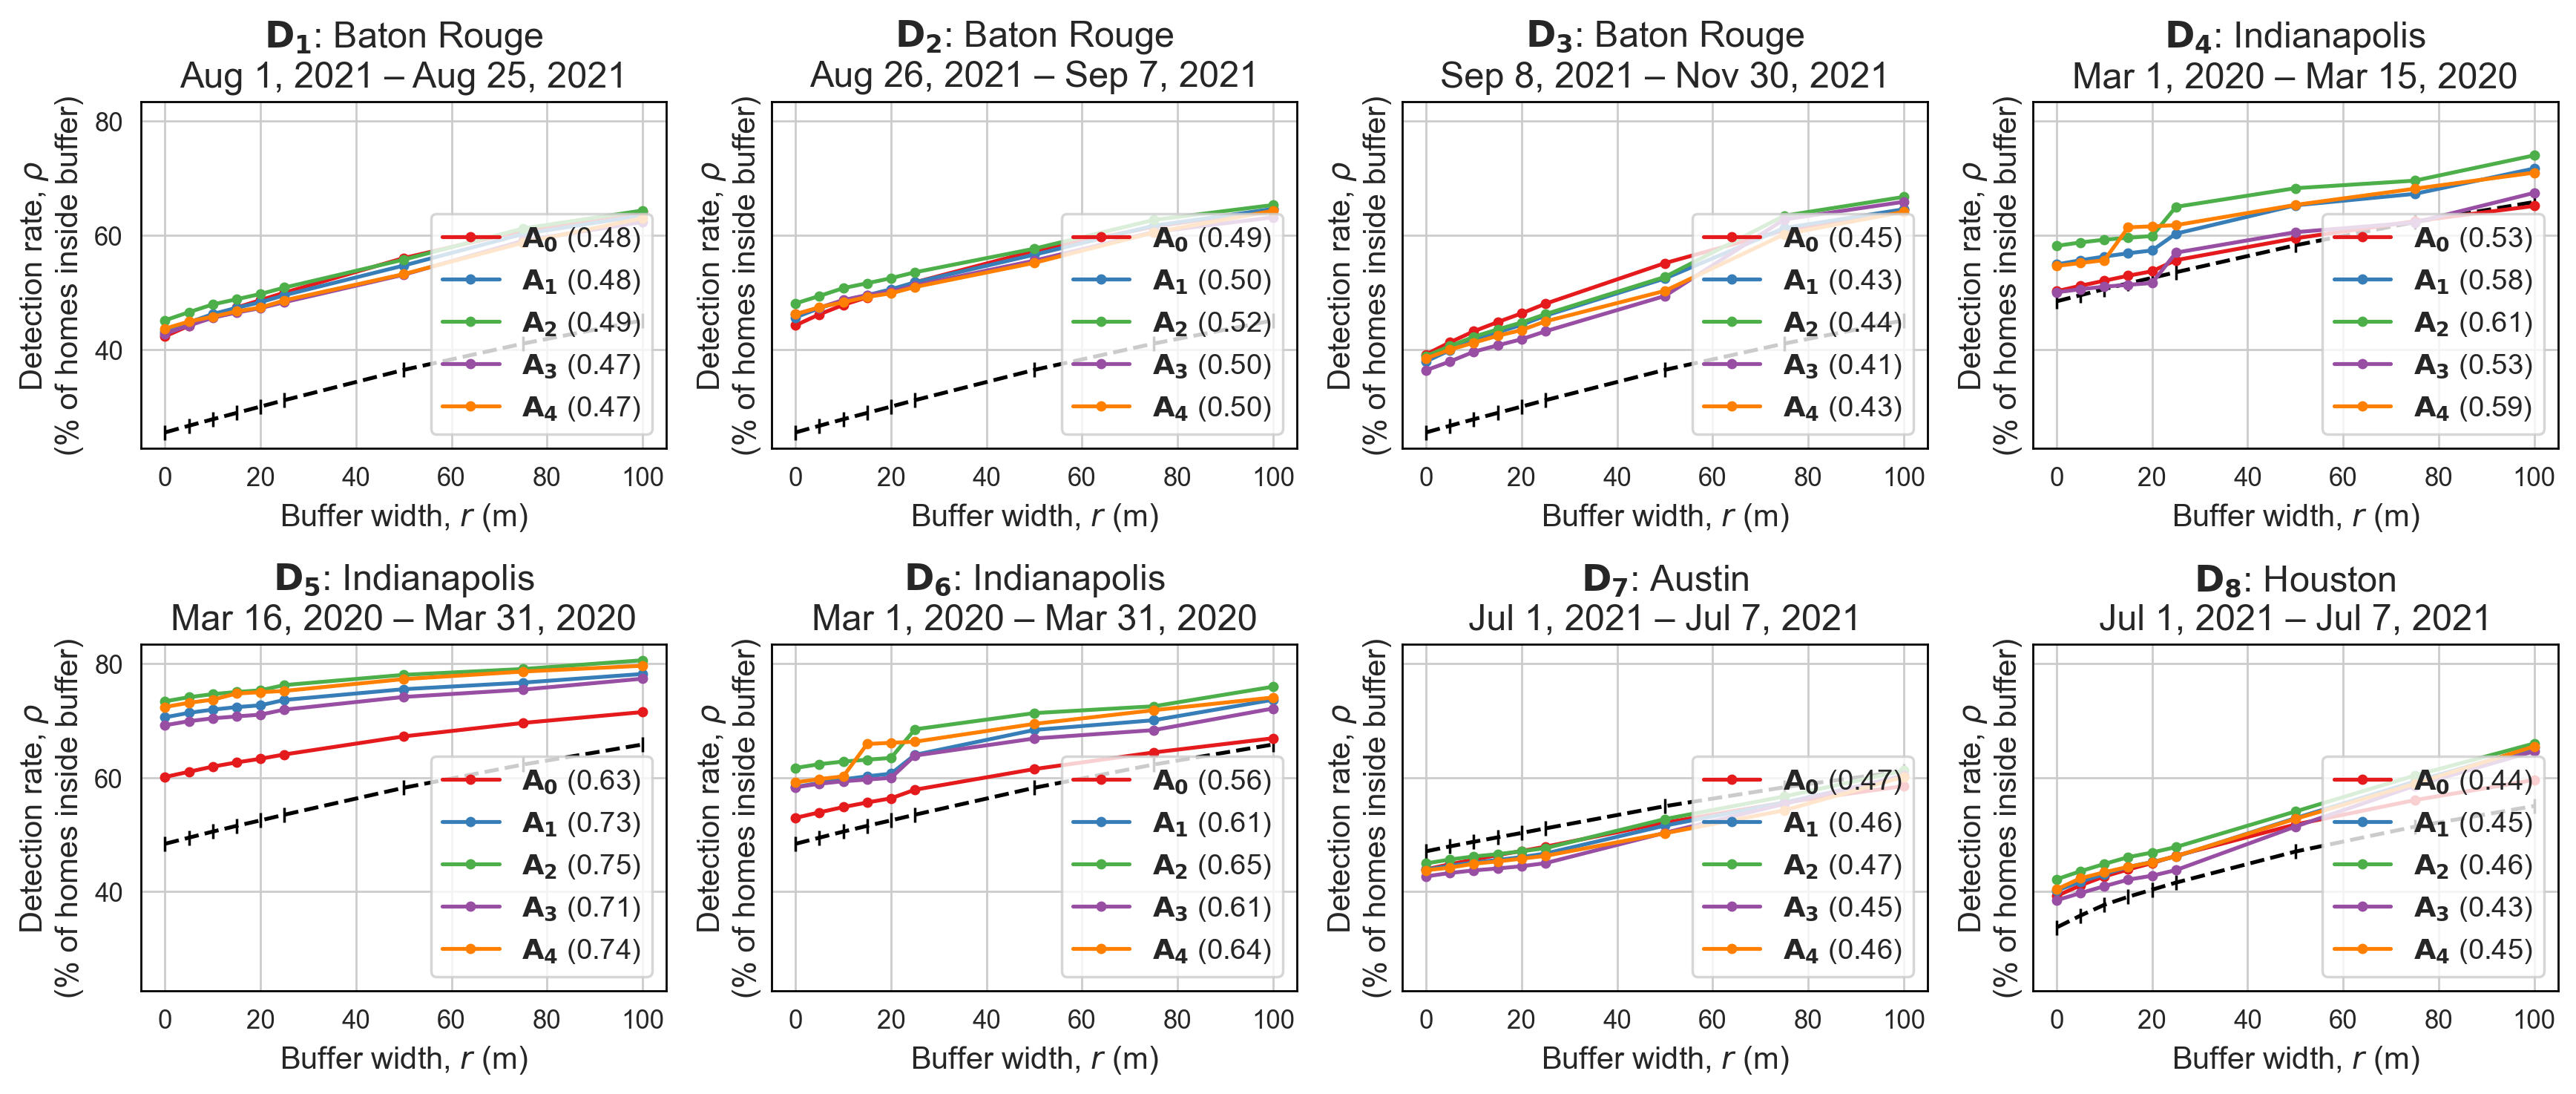

In [67]:
def fig_m1(datasets=datasets, algos=algos, max_buf=np.inf, colors=algo_colors, 
           ncol=4, vmax=5, bins=100, cum=True, panel_size=(3.5, 3), dpi=120):
    nrow = int(np.ceil(len(datasets) / ncol))
    figsize = (ncol * panel_size[0], nrow * panel_size[1])
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, dpi=dpi, sharey=True)
    for i, (ax, ds) in enumerate(tqdm(list(zip(axes.flatten(), datasets)))):
        rgn = ds.region
        lu = gpd.read_parquet(rgn.geom / 'land_use/resi_nonresi.parquet')
        lu_area = lu.to_crs(CRS_M).area.sum()
        resi = rgn.resi.query(f'buffer <= {max_buf}').set_index('buffer').to_crs(CRS_M)
        resi['pct_area'] = resi.area / lu_area * 100
        ax = U.plot(ax, framebordercolor='k')
        ax.plot(resi.index, resi['pct_area'], marker='|', color='k', ls='--', lw=1.5)
        for alg, color in zip(algos, algo_colors):
            df = pd.read_parquet(rgn.data / f'metrics/{ds.name}/{alg}/M1.parquet')
            df = df[df['buffer'] <= max_buf]
            x, y = df['buffer'].values, df['det_rate'].values
            # m1 = (y * (x.max() - x)).sum() / (y.sum() * x.max())
            m1 = (y * (x.max() - x)).sum() / (x.max() - x).sum() / 100
            label = '$\mathbf{%s}$ (%0.2f)' % (f'{alg[0]}_{alg[1]}', m1)
            ax.plot(x, y, marker='.', color=color, label=label, lw=1.5)
        title = '$\mathbf{D_%d}$: %s\n%s' % (i+1, rgn.name, ds.fmt_dates(fmt='%-b %-d, %Y'))
        ax = U.plot(ax, title=title, xlab=r'Buffer width, $r$ (m)', 
                    ylab=r'Detection rate, $\rho$'+'\n(% of homes inside buffer)')
        ax.legend(loc='lower right')
    plt.tight_layout()
    
%time x = fig_m1(dpi=250, max_buf=100); x # t=0:48

## M2 curves

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 13.5 s, sys: 3.52 s, total: 17 s
Wall time: 11.3 s


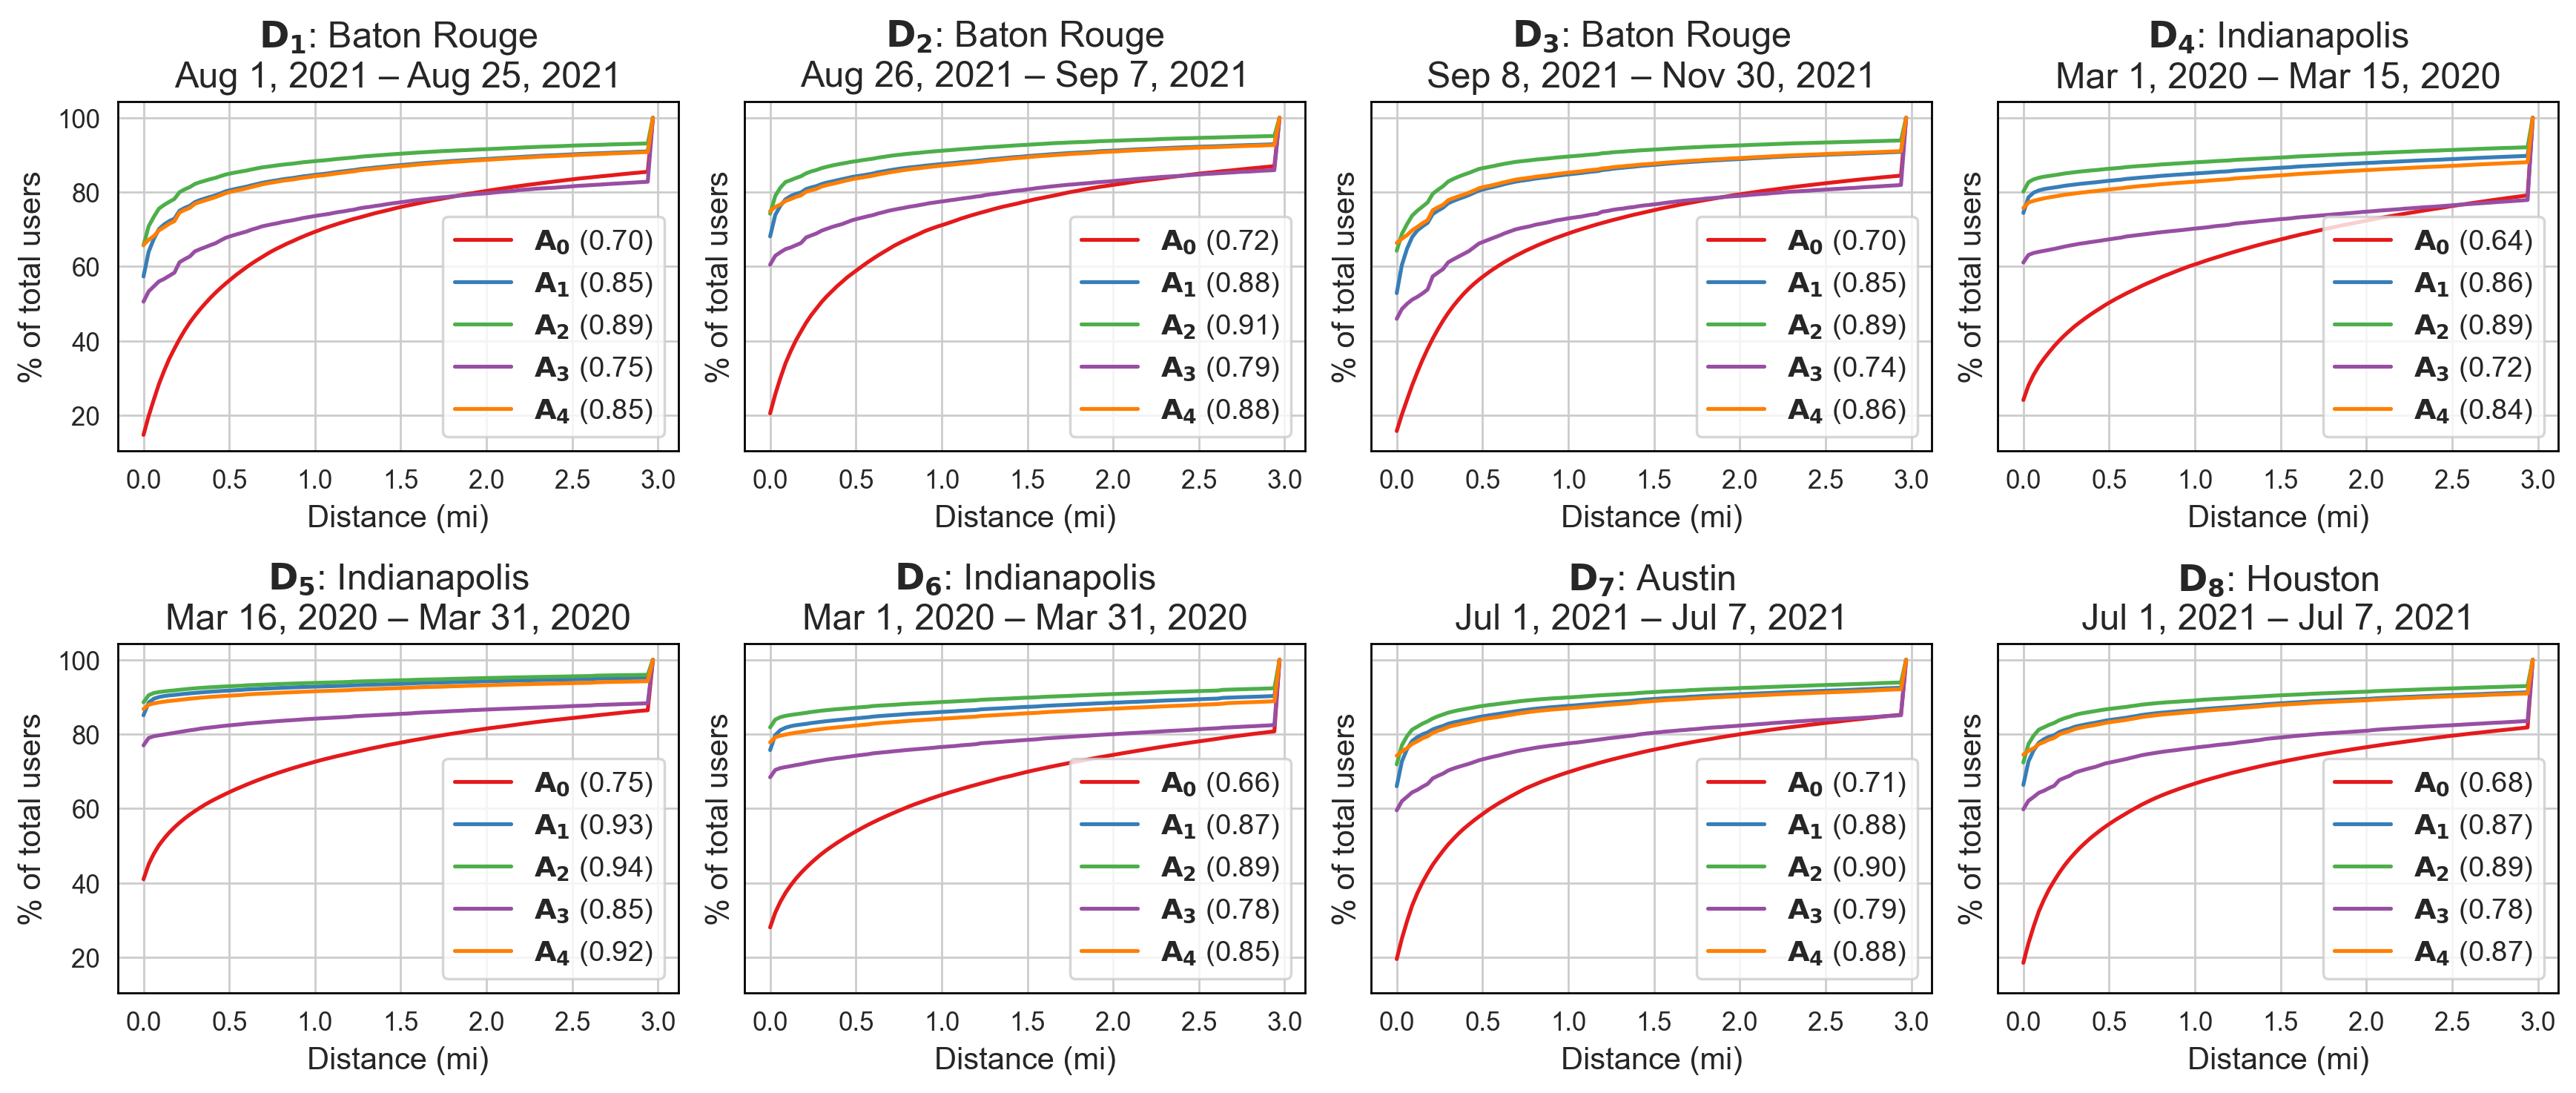

In [68]:
def fig_m2(datasets=datasets, algos=algos, colors=algo_colors, ylog=False,
           ncol=4, vmax=3, bins=100, cum=True, panel_size=(3.5, 3), dpi=120):
    nrow = int(np.ceil(len(datasets) / ncol))
    figsize = (ncol * panel_size[0], nrow * panel_size[1])
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, dpi=dpi, sharey=True)
    for i, (ax, ds) in enumerate(tqdm(list(zip(axes.flatten(), datasets)))):
        rgn = ds.region
        ax = U.plot(ax, framebordercolor='k')
        for alg, color in zip(algos, algo_colors):
            df = pd.read_parquet(rgn.data / f'metrics/{ds.name}/{alg}/M2.parquet')
            # for j, (agg_fn, ls) in enumerate([(np.median, '-'), (np.mean, '--')]):
            for j, (agg_fn, ls) in enumerate([(np.median, '-')]):
                df2 = df.groupby(UID)['dist'].agg(agg_fn)
                y, x = np.histogram((df2.values * U.M2MI).clip(0, vmax), bins=bins)
                y = (y.cumsum() if cum else y) / y.sum() * 100
                m2 = y.sum() / (100 * len(y))
                label = '$\mathbf{%s}$ (%0.2f)' % (f'{alg[0]}_{alg[1]}', m2)
                ax.plot(x[:-1], y, color=color, ls=ls,
                        label=label if j == 0 else None)
        title = '$\mathbf{D_%d}$: %s\n%s' % (i+1, rgn.name, ds.fmt_dates(fmt='%-b %-d, %Y'))
        ax = U.plot(ax, title=title, xlab='Distance (mi)', ylab='% of total users', ylog=ylog)
        ax.legend()
    plt.tight_layout()

%time x = fig_m2(dpi=250); x # t=0:08

## M3 curves

## Sensitivity analysis

### Lorenz curve

CPU times: user 2.49 s, sys: 518 ms, total: 3.01 s
Wall time: 8.3 s


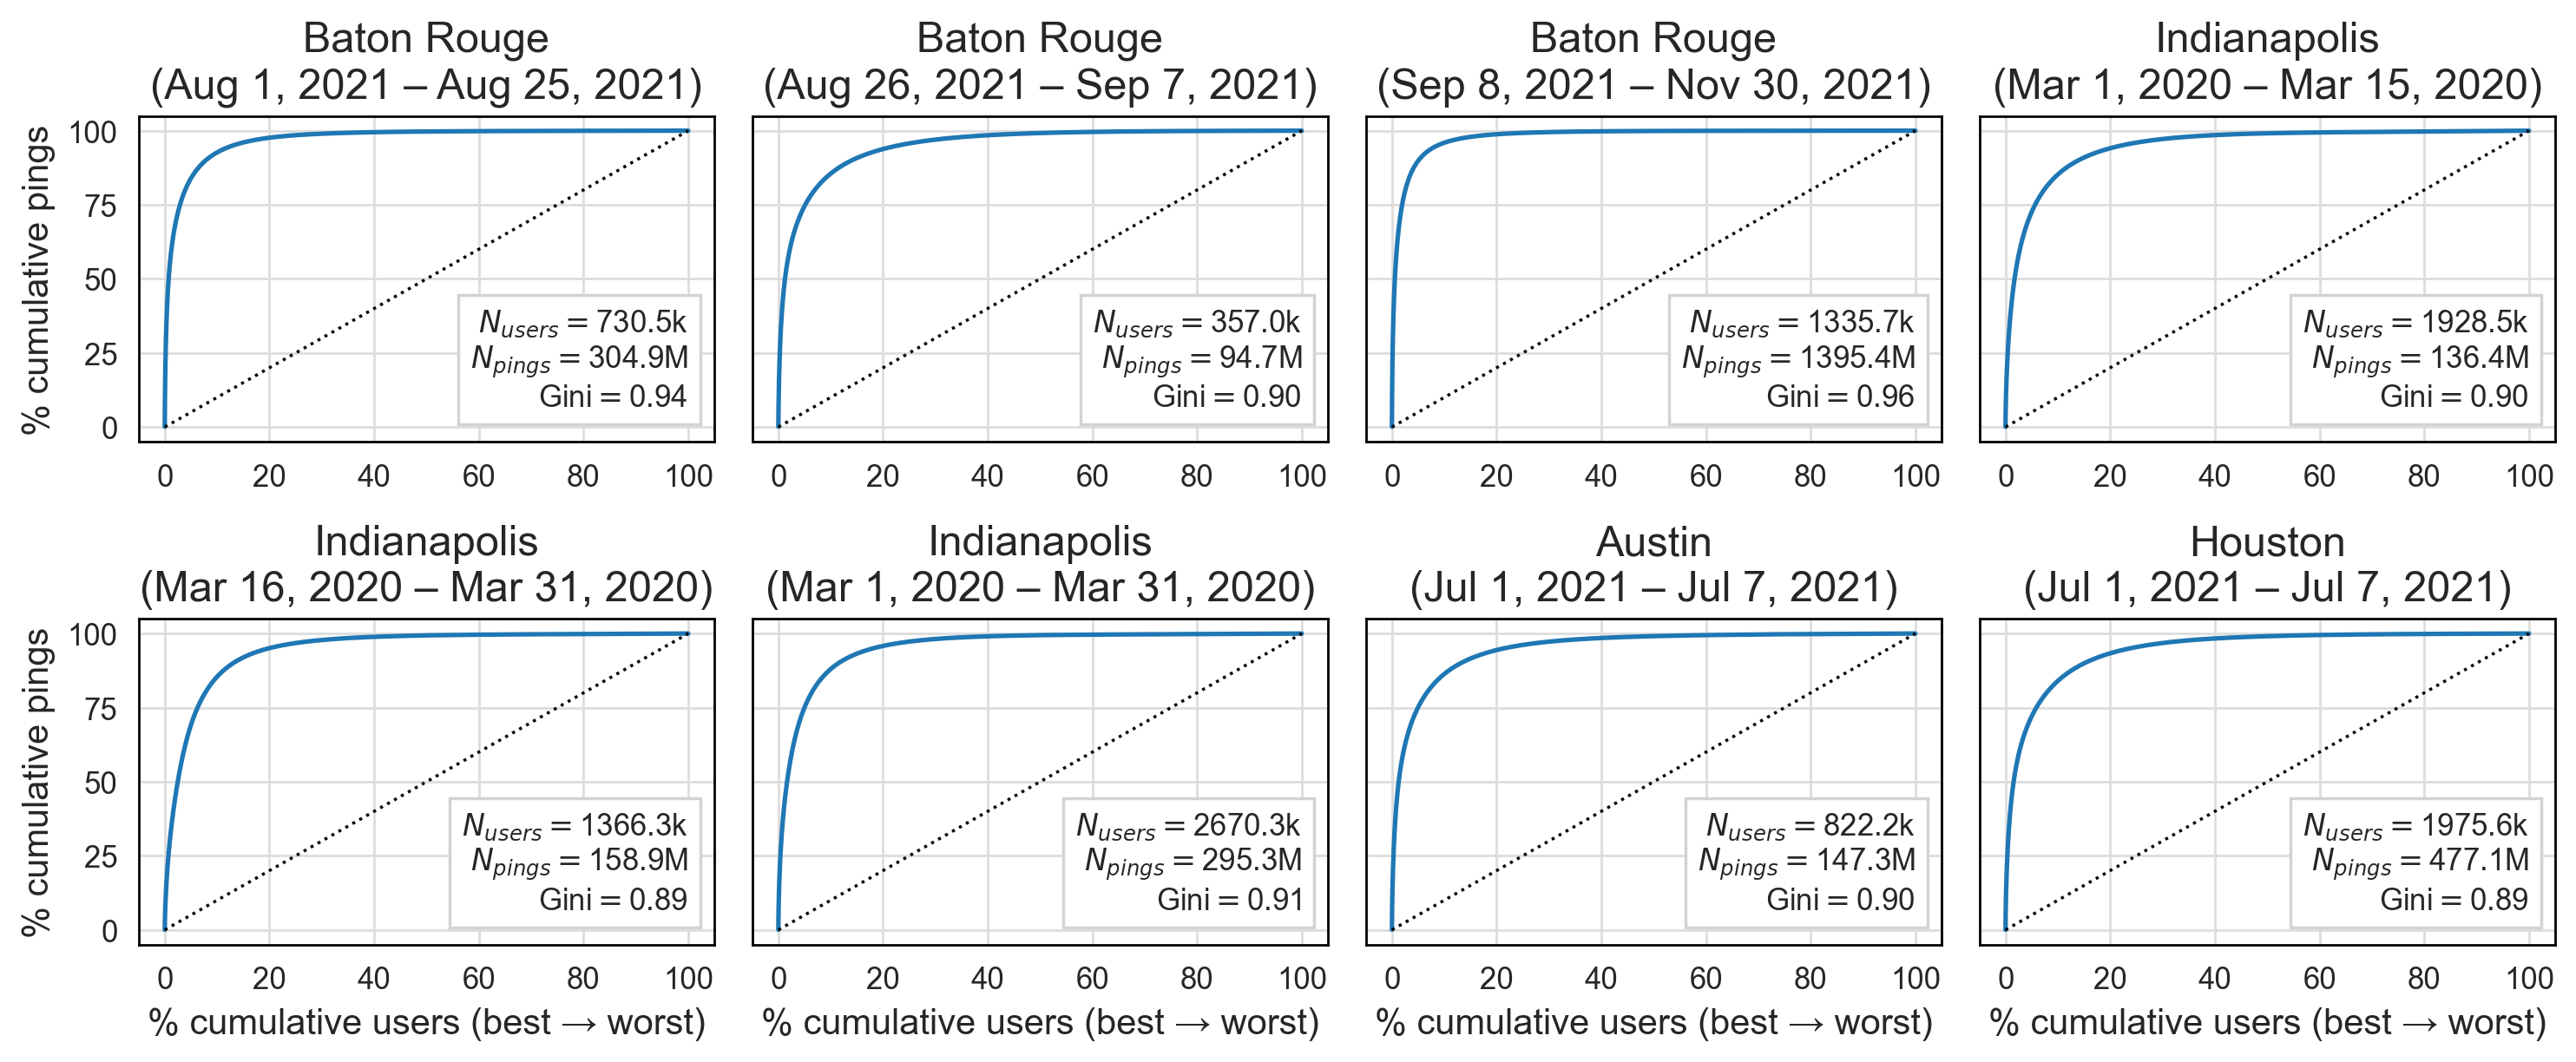

In [69]:
def get_user_ping_count_lorenz_curve(datasets, ncol=4, size=(3, 2.5), dpi=120):
    nrow = int(np.ceil(len(datasets) / ncol))
    fig, axes = plt.subplots(nrow, ncol, dpi=dpi, sharey=True,
                             figsize=(size[0] * ncol, size[1] * nrow))
    for i, j in it.product(range(nrow), range(ncol)):
        k = i * ncol + j
        if k >= len(datasets):
            axes[i, j].axis('off')
            continue
        ds = datasets[k]
        df = get_ping_counts(ds).sort(F.col('n_pings').desc())
        y = df.toPandas()['n_pings']
        nUsers, nPings = len(y), sum(y)
        y = y.cumsum() / y.sum()
        title = f'{ds.region.name}\n({ds.fmt_dates(fmt="%-b %-d, %Y")})'
        ax = U.plot(axes[i, j], title=title, framebordercolor='k', gridcolor='#ddd',
                    xlab='% cumulative users (best → worst)' if i == nrow - 1 else '',
                    ylab='% cumulative pings' if j == 0 else '')
        ax.plot(y.index / len(y) * 100, y * 100)
        ax.plot([0, 100], [0, 100], ls=':', lw=1, color='k')
        gini = 2 * (y.sum() / len(y)) - 1
        ax.text(100, 5, '$N_{users}=$%.1fk\n$N_{pings}=$%.1fM\nGini$=$%.2f' %
                (nUsers / 1000, nPings / 1e6, gini), va='bottom', ha='right',
                bbox=dict(facecolor='w', edgecolor='lightgrey'))
    plt.tight_layout()

%time get_user_ping_count_lorenz_curve(datasets, dpi=250)

In [70]:
def get_lu_detection_rate(ds, alg, max_buffer=200, bins=100):
    rgn, dates, ds_name = ds.region, ds.dates, ds.name
    users = (SP.read_parquet(rgn.data / f'night_pings/{ds_name}')
             .withColumn('n_pings', F.size(LON))
             .groupby(UID).agg(F.sum('n_pings').alias('n_pings'))
             .sort(F.col('n_pings').desc()).toPandas())
    homes = pd.read_parquet(rgn.data / f'homes/{ds_name}')
    homes = mk.geo.pdf2gdf(homes, LON, LAT, CRS_DEG).set_index(UID)
    users = users.merge(homes.reset_index()[[UID]], on=UID)
    n_homes = len(homes)
    resi = rgn.R[rgn.R.index <= max_buffer] if max_buffer else rgn.R
    y, nU = [], []
    for buffer, row in resi.sort_index().iterrows():
        resi = Gdf({'geometry': [row.geometry]}, crs=CRS_DEG)
        within = gpd.sjoin(homes, resi, predicate='within').index
        within = Pdf({'present': True}, index=within)
        df = users.merge(within, how='left', on=UID).fillna(False)
        slices = np.linspace(0, len(df)+1, bins).astype(int)[1:]
        y.append(Seq([df.iloc[:idx]['present'].sum() for idx in slices], name=buffer))
    y = pd.concat(y, axis=1).T
    m1 = y.apply(lambda x: (x * (x.index.max() - x.index)).sum() / 
                   (x.sum() * x.index.max()))
    return m1

%time x = get_lu_detection_rate(datasets[0], 'A1'); x

AttributeError: 'Region' object has no attribute 'R'

In [ ]:
def get_m1_lorenz_curve(datasets, algos, ncol=4, agg_fn=np.median, colors=algo_colors, 
                        size=(4, 3), dpi=120, bins=100):
    nrow = int(np.ceil(len(datasets) / ncol))
    fig, axes = plt.subplots(nrow, ncol, dpi=dpi, sharey=True,
                             figsize=(size[0] * ncol, size[1] * nrow))
    for i, (ds, ax) in enumerate(list(zip(datasets, axes))):
        for alg, color in zip(algos, colors):
            m1 = get_lu_detection_rate(rgn, alg)
            ax.plot(np.linspace(0, 100, len(m1)), m1, color=color, label=alg)
        ax.legend(ncol=int(np.ceil(len(algos) / 2)), loc='lower center')
        U.plot(ax, title=rgn.name, ylab='$M_1$ value (percent)' if i == 0 else '',
               framebordercolor='k', xlab='% cumulative users (best → worst)')
    plt.tight_layout()
    P.imsave('M1 Lorenz curve - {}'.format(', '.join([rgn.name for rgn in rgns])))

%time x = get_m1_lorenz_curve(datasets, algos, dpi=100); x

In [73]:
def get_m2_lorenz_curve(rgns, algos, agg_fn=np.median, colors=algo_colors,
                        size=(4, 3), dpi=120, bins=100):
    fig, axes = plt.subplots(1, len(rgns), dpi=dpi, sharey=True,
                             figsize=(size[0] * len(rgns), size[1]))
    if len(rgns) == 1: axes = [axes]
    for i, (rgn, ax) in enumerate(list(zip(rgns, axes))):
        for alg, color in zip(algos, colors):
            df = (rgn.traj_proxi[alg].drop(columns=['n_pings'])
                  .groupby(UID)['dist'].agg(agg_fn).reset_index()
                  .merge(rgn.user_ping_count, on=UID)
                  .sort_values('n_pings', ascending=False)
                  .drop(columns='n_pings').reset_index(drop=True))
            m2 = []
            for idx in np.linspace(0, len(df)+1, bins).astype(int)[1:]:
                y = df.loc[:idx]['dist']
                y = y.cumsum() / y.sum()
                m2.append(y.sum() / len(y))
            ax.plot(np.linspace(0, 100, len(m2)), m2, color=color, label=alg)
        ax.legend(ncol=int(np.ceil(len(algos) / 2)), loc='lower center')
        U.plot(ax, title=rgn.name, ylab='$M_2$ value (percent)' if i == 0 else '',
               framebordercolor='k', xlab='% cumulative users (best → worst)')
    plt.tight_layout()
    P.imsave('M2 Lorenz curve - {}'.format(', '.join([rgn.name for rgn in rgns])))

%time x = get_m2_lorenz_curve(rgns, algos, dpi=250); x

NameError: name 'rgns' is not defined

# Miscellaneous

## Sample summary

## Study periods